In [1]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import CelebA
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from dcgan_network import Generator as DCGAN
import torchvision.datasets as dset

torch.manual_seed(0)

### Evaluate DCGAN images for deepweeds

In [2]:
#load our DC GAN model
MODEL_PATH = "Model/deepweeds_DCGAN_gan_0.pth"
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
#num of gpu
ngpu = 1

#image size
image_size = 299

dcgan = DCGAN(ngpu, nz, ngf, nc)
dcgan.load_state_dict(torch.load(MODEL_PATH))
dcgan = dcgan.cuda()
dcgan.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [3]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [4]:
#fucntion to display some images
def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.figure(figsize=(8,8))
    if show:
        plt.show()

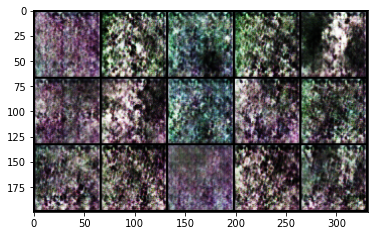

<Figure size 576x576 with 0 Axes>

In [5]:
#View some genaretd images
noise = torch.randn(15, nz, 1, 1, device=device)
        # Generate fake image batch with G
fake = dcgan(noise)
show_tensor_images(fake, size=(3, 64, 64))

In [6]:
from torchvision.models import inception_v3
import torchvision.models as models
import torch.utils.model_zoo as model_zoo
incpetion_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
inception_model = inception_v3(pretrained=False)


state_dict = model_zoo.load_url(incpetion_url)
inception_model.load_state_dict(state_dict)
inception_model.to(device)
inception_model = inception_model.eval()

C:\Users\rashe\anaconda3\lib\site-packages\torchvision\models\inception.py:81: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '


In [7]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CELL: inception_model.fc

# You want to replace the final fully-connected (fc) layer 
# with an identity function layer to cut off the classification
# layer and get a feature extractor
#### START CODE HERE ####
inception_model.fc = nn.Identity()
#### END CODE HERE ####

In [8]:
# UNIT TEST
test_identity_noise = torch.randn(100, 100)
assert torch.equal(test_identity_noise, inception_model.fc(test_identity_noise))
print("Success!")

Success!


In [9]:
#source

#helper functions to calculate frechet distance
import scipy
# This is the matrix square root function you will be using
def matrix_sqrt(x):
    '''
    Function that takes in a matrix and returns the square root of that matrix.
    For an input matrix A, the output matrix B would be such that B @ B is the matrix A.
    Parameters:
        x: a matrix
    '''
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)


# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: frechet_distance
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    '''
    Function for returning the Fréchet distance between multivariate Gaussians,
    parameterized by their means and covariance matrices.
    Parameters:
        mu_x: the mean of the first Gaussian, (n_features)
        mu_y: the mean of the second Gaussian, (n_features) 
        sigma_x: the covariance matrix of the first Gaussian, (n_features, n_features)
        sigma_y: the covariance matrix of the second Gaussian, (n_features, n_features)
    '''
    #### START CODE HERE ####
    return torch.norm(mu_x-mu_y, p=2) + torch.trace(sigma_x + sigma_y - 2*matrix_sqrt(sigma_x).mm(matrix_sqrt(sigma_y)))
    #### END CODE HERE ####

In [10]:
#preprocess images for inception
def preprocess(img):
    img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
    return img

In [11]:
#function to determine covariance
import numpy as np
def get_covariance(features):
    return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

In [12]:
fake_features_list = []
real_features_list = []

n_samples = 512 # The total number of samples
batch_size = 4 # Samples per iteration
z_dim = 100

# Root directory for dataset
dataroot = "data/train/"
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)



In [13]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, 1, 1, device=device)

In [16]:
cur_samples = 0
with torch.no_grad(): # You don't need to calculate gradients here, so you do this to save memory
    try:
        for real_example, _ in tqdm(dataloader, total=n_samples // batch_size): # Go by batch
            real_samples = real_example
            real_features = inception_model(real_samples.to(device)) # Move features to CPU
            real_features_list.append(real_features)

            fake_samples = get_noise(len(real_example), z_dim).to(device)
            fake_samples = preprocess(dcgan(fake_samples))
            fake_features = inception_model(fake_samples.to(device))
            fake_features_list.append(fake_features)
            cur_samples += len(real_samples)
            if cur_samples >= n_samples:
                break
    except:
        print("Error in loop")

  0%|          | 0/128 [00:03<?, ?it/s]

Then combine all of the values that you collected for the reals and fakes into large tensors:

In [17]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# UNIT TEST COMMENT: Needed as is for autograding
fake_features_all = torch.cat(fake_features_list)
real_features_all = torch.cat(real_features_list)

calculate the covariance and means of these real and fake features:

In [23]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CELL

# Calculate the covariance matrix for the fake and real features
# and also calculate the means of the feature over the batch (for each feature dimension mean)
#### START CODE HERE ####
mu_fake = torch.mean(fake_features_all, dim=0).detach().to('cpu')
mu_real = torch.mean(real_features_all, dim=0).detach().to('cpu')
sigma_fake = get_covariance(fake_features_all.detach().to('cpu'))
sigma_real = get_covariance(real_features_all.detach().to('cpu'))
#### END CODE HERE ####

In [24]:
assert tuple(sigma_fake.shape) == (fake_features_all.shape[1], fake_features_all.shape[1])
# assert torch.abs(sigma_fake[0, 0] - 2.5e-2) < 1e-2 and torch.abs(sigma_fake[-1, -1] - 5e-2) < 1e-2
assert tuple(sigma_real.shape) == (real_features_all.shape[1], real_features_all.shape[1])
# assert torch.abs(sigma_real[0, 0] - 3.5768e-2) < 1e-4 and torch.abs(sigma_real[0, 1] + 5.3236e-4) < 1e-4
assert tuple(mu_fake.shape) == (fake_features_all.shape[1],)
assert tuple(mu_real.shape) == (real_features_all.shape[1],)
# assert torch.abs(mu_real[0] - 0.3099) < 0.01 and torch.abs(mu_real[1] - 0.2721) < 0.01
# assert torch.abs(mu_fake[0] - 0.37) < 0.05 and torch.abs(mu_real[1] - 0.27) < 0.05
print("Success!")

Success!


Visualize what the pairwise multivariate distributions of the inception features look like!

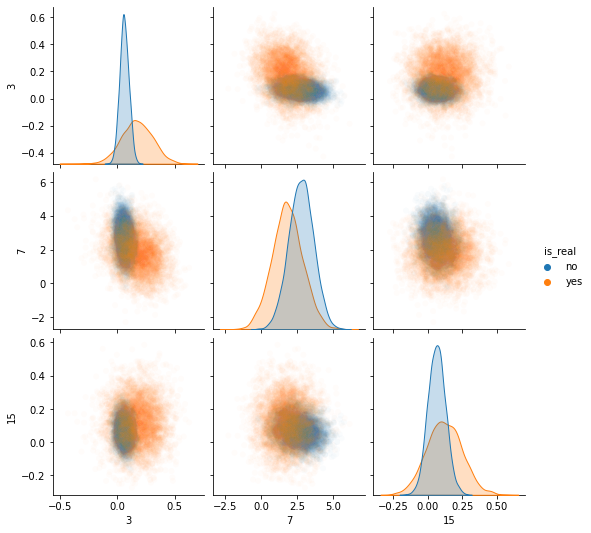

In [91]:
import pandas as pd
from torch.distributions import MultivariateNormal
import seaborn as sns 

indices = [3, 7, 15]
fake_dist = MultivariateNormal(mu_fake[indices], sigma_fake[indices][:, indices])
fake_samples = fake_dist.sample((5000,))
real_dist = MultivariateNormal(mu_real[indices], sigma_real[indices][:, indices])
real_samples = real_dist.sample((5000,))


df_fake = pd.DataFrame(fake_samples.numpy(), columns=indices)
df_real = pd.DataFrame(real_samples.numpy(), columns=indices)
df_fake["is_real"] = "no"
df_real["is_real"] = "yes"
df = pd.concat([df_fake, df_real]).reset_index(drop=True)
#Prevent duplicate values in a DataFrame index
sns_plt = sns.pairplot(df, plot_kws={'alpha': 0.02}, hue='is_real')
sns_plt.savefig("DCGAN_frechet.png")

Finally calculate the Frechet distance

In [59]:
with torch.no_grad():
    print(frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())

175.40330505371094


In [90]:
mu_fake[[2,4]]

tensor([0.0017, 0.3741])